# Pré-Processamento UEL - Gerando dados para treinamento

In [ ]:
import pandas as pd
from itertools import cycle
import random

# 1. Carregar os arquivos originais
teste_ataque      = pd.read_csv('data/cic_puro/teste_ataque_ordenado.csv',     sep=';')
teste_normal      = pd.read_csv('data/cic_puro/teste_sem_ataque_ordenado.csv', sep=';')
treino_ataque     = pd.read_csv('data/cic_puro/treino_ataque_ordenado.csv',    sep=';')
treino_normal     = pd.read_csv('data/cic_puro/treino_sem_ataque_ordenado.csv',sep=';')
validacao_ataque  = pd.read_csv('data/cic_puro/treino_ataque_ordenado.csv',    sep=';')  # igual ao treino
validacao_normal  = pd.read_csv('data/cic_puro/treino_sem_ataque_ordenado.csv',sep=';')  # igual ao treino

# 2. Concatenar para os três conjuntos
teste_full      = pd.concat([teste_normal,      teste_ataque],     ignore_index=True)
treino_full     = pd.concat([treino_normal,     treino_ataque],    ignore_index=True)
validacao_full  = pd.concat([validacao_normal,  validacao_ataque], ignore_index=True)

# 3. Função para separar normais e ataques, limitando quantidades
def prepare_data(df, max_per_attack=1000, max_normal=None):
    normal  = df[df['label']==0].sample(frac=1).reset_index(drop=True)
    attacks = df[df['label']==1].reset_index(drop=True)

    # limita por tipo de ataque
    attack_dict = {
        name: grp.sample(n=min(len(grp), max_per_attack)).reset_index(drop=True)
        for name, grp in attacks.groupby('attack_name')
    }

    # limita normais, se desejado
    if max_normal is not None:
        normal = normal.sample(n=min(len(normal), max_normal)).reset_index(drop=True)

    return normal, attack_dict

# 3a. Preparar dados para treino
train_normal,   train_attacks   = prepare_data(treino_full,    max_per_attack=1000, max_normal=10000)
# 3b. Preparar dados para validação (vem de validacao_full)
valid_normal,   valid_attacks   = prepare_data(validacao_full, max_per_attack=500,  max_normal=5000)
# 3c. Preparar dados para teste (baseado em treino_full, mesma forma do treino)
test_normal,    test_attacks    = prepare_data(treino_full,    max_per_attack=1000, max_normal=10000)

# 4. Função para gerar sequências aleatórias
def create_random_sequences(normal_df, attack_dict, min_seq=30, max_seq=120):
    rows = []
    norm_iter = normal_df.iterrows()
    atk_iters = {k: v.iterrows() for k, v in attack_dict.items()}
    atk_cycle = cycle(list(atk_iters.keys()))
    norm_rem, atk_rem = True, True

    while norm_rem or atk_rem:
        choice = random.choice(['normal','attack'])
        if choice=='normal' and norm_rem:
            L = random.randint(min_seq, max_seq)
            for _ in range(L):
                try:
                    _, row = next(norm_iter)
                    rows.append(row)
                except StopIteration:
                    norm_rem=False
                    break
        elif choice=='attack' and atk_rem:
            atk = next(atk_cycle)
            L   = random.randint(min_seq, max_seq)
            for _ in range(L):
                try:
                    _, row = next(atk_iters[atk])
                    rows.append(row)
                except StopIteration:
                    del atk_iters[atk]
                    if atk_iters:
                        atk_cycle = cycle(atk_iters.keys())
                    else:
                        atk_rem = False
                    break
        else:
            # tipo esgotado, tenta o outro
            continue

    return pd.DataFrame(rows)

# 5. Gerar os três conjuntos de saída
train_final = create_random_sequences(train_normal, train_attacks)
valid_final = create_random_sequences(valid_normal, valid_attacks)
test_final  = create_random_sequences(test_normal,  test_attacks)

# 6. Salvar cada CSV com o nome correto
train_final.to_csv('treino_final_estratificado_random.csv',      sep=';', index=False)
valid_final.to_csv('validacao_final_estratificado_random.csv',  sep=';', index=False)
test_final.to_csv( 'teste_final_estratificado_random.csv',      sep=';', index=False)

print('Arquivos gerados:')
print(' • treino_final_estratificado_random.csv')
print(' • validacao_final_estratificado_random.csv')
print(' • teste_final_estratificado_random.csv')


Arquivos gerados:
 • treino_final_estratificado_random.csv
 • validacao_final_estratificado_random.csv
 • teste_final_estratificado_random.csv


In [7]:
# Contar a quantidade de cada valor na coluna 'attack_name'
attack_counts_train = train_final['attack_name'].value_counts()
attack_counts_test = test_final['attack_name'].value_counts()
attack_counts_valid = valid_final['attack_name'].value_counts()

# Exibir os resultados
print('Tamanho:', len(train_final), 'Treino:', attack_counts_train)
print('Total de linhas no conjunto de treino:', len(train_final))

print('Tamanho:', len(test_final), 'Teste:', attack_counts_test)
print('Total de linhas no conjunto de teste:', len(test_final))

print('Tamanho:', len(valid_final), 'Validação:', attack_counts_valid)
print('Total de linhas no conjunto de validação:', len(valid_final))

Tamanho: 17148 Treino: attack_name
normal           8074
DrDoS_DNS        1000
DrDoS_NTP        1000
DrDoS_SNMP       1000
DrDoS_UDP        1000
TFTP             1000
UDP-lag           885
DrDoS_SSDP        822
DrDoS_NetBIOS     726
DrDoS_MSSQL       687
DrDoS_LDAP        592
Syn               237
WebDDoS           125
Name: count, dtype: int64
Total de linhas no conjunto de treino: 17148
Tamanho: 17148 Teste: attack_name
normal           8074
DrDoS_DNS        1000
DrDoS_NTP        1000
DrDoS_SNMP       1000
DrDoS_UDP        1000
TFTP             1000
UDP-lag           885
DrDoS_SSDP        822
DrDoS_NetBIOS     726
DrDoS_MSSQL       687
DrDoS_LDAP        592
Syn               237
WebDDoS           125
Name: count, dtype: int64
Total de linhas no conjunto de teste: 17148
Tamanho: 10362 Validação: attack_name
normal           5000
DrDoS_DNS         500
DrDoS_LDAP        500
DrDoS_MSSQL       500
DrDoS_NTP         500
DrDoS_NetBIOS     500
DrDoS_SNMP        500
DrDoS_SSDP        500
DrDo

# Modelos

## LSTM

In [1]:
from models.LSTM import LSTM
from models.Sequence import SequenceDataset
from torch.utils.data import DataLoader
import torch

# Configurações gerais
SEED = 42
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Parâmetros do dataset e modelo
input_size      = 9
hidden_size     = 256
num_layers      = 3
output_size     = 2
batch_size      = 128
sequence_length = 50
column_to_remove= 'attack_name'

Usando dispositivo: cuda


### Treinamento

In [2]:
# Criar os datasets
train_dataset = SequenceDataset(
    path             = 'data/dataset/treino_final_estratificado_random.csv',
    sequence_length  = sequence_length,
    column_to_remove = column_to_remove,
    normalize        = True,
    mode             = 'lstm'
)
valid_dataset = SequenceDataset(
    path             = 'data/dataset/validacao_final_estratificado_random.csv',
    sequence_length  = sequence_length,
    column_to_remove = column_to_remove,
    normalize        = True,
    mode             = 'lstm'
)

print(f"Total de amostras no treino: {len(train_dataset)}")
print(f"Total de amostras na validação:  {len(valid_dataset)}")
print("Train Shape:", train_dataset.sequences.shape)
print("Valid  Shape:", valid_dataset.sequences.shape)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader  = DataLoader(valid_dataset,  batch_size=batch_size)
print(f"Batches treino: {len(train_loader)}, teste: {len(valid_loader)}")

# Instanciar o modelo
model = LSTM(input_size=input_size,
             hidden_size=hidden_size,
             num_layers=num_layers,
             output_size=output_size).to(device)
print(model)

Total de amostras no treino: 17099
Total de amostras na validação:  10313
Train Shape: torch.Size([17099, 50, 9])
Valid  Shape: torch.Size([10313, 50, 9])
Batches treino: 134, teste: 81
LSTM(
  (lstm1): LSTM(9, 128, num_layers=3, batch_first=True)
  (lstm2): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.2)
  (lstm3): LSTM(256, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


In [3]:
# Treina e salva
model.train_model(
    train_loader,
    valid_loader,
    device=device,
    epochs=50,
    lr=1e-3,
    save_dir='output/LSTM',
    threshold=0.90
)

Epoch 1/50 – Train Loss: 0.3492  Val Loss: 0.1858  Val Acc: 0.9431
→ Novo melhor modelo salvo em 'output/LSTM\LSTM_best_model.pth'
Epoch 2/50 – Train Loss: 0.1674  Val Loss: 0.1101  Val Acc: 0.9674
→ Novo melhor modelo salvo em 'output/LSTM\LSTM_best_model.pth'
Epoch 3/50 – Train Loss: 0.1129  Val Loss: 0.1208  Val Acc: 0.9647
Epoch 4/50 – Train Loss: 0.0979  Val Loss: 0.1261  Val Acc: 0.9636
Epoch 5/50 – Train Loss: 0.0943  Val Loss: 0.0995  Val Acc: 0.9679
→ Novo melhor modelo salvo em 'output/LSTM\LSTM_best_model.pth'
Epoch 6/50 – Train Loss: 0.1169  Val Loss: 0.0999  Val Acc: 0.9692
→ Novo melhor modelo salvo em 'output/LSTM\LSTM_best_model.pth'
Epoch 7/50 – Train Loss: 0.0857  Val Loss: 0.1034  Val Acc: 0.9699
→ Novo melhor modelo salvo em 'output/LSTM\LSTM_best_model.pth'
Epoch 8/50 – Train Loss: 0.0821  Val Loss: 0.1186  Val Acc: 0.9631
Epoch 9/50 – Train Loss: 0.0670  Val Loss: 0.1107  Val Acc: 0.9669
Epoch 10/50 – Train Loss: 0.0611  Val Loss: 0.1596  Val Acc: 0.9545
Epoch 11/

LSTM(
  (lstm1): LSTM(9, 128, num_layers=3, batch_first=True)
  (lstm2): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.2)
  (lstm3): LSTM(256, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

### Avaliação

In [4]:
test_dataset = SequenceDataset(
    path             = 'data/dataset/teste_final_estratificado_random.csv',
    sequence_length  = sequence_length,
    column_to_remove = column_to_remove,
    normalize        = True,
    mode             = 'lstm'
)

test_loader  = DataLoader(test_dataset,  batch_size=batch_size)

# Instanciar o modelo e mover para device
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Carregar o checkpoint salvo 
checkpoint_path = 'output/LSTM/LSTM_best_model.pth'
state = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state)
print(f"Checkpoint '{checkpoint_path}' carregado com sucesso!")

# Avaliar o modelo
model.evaluate(test_loader, device=device)

Checkpoint 'output/LSTM/LSTM_best_model.pth' carregado com sucesso!

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9703    0.9611    0.9657      8025
           1     0.9659    0.9740    0.9699      9074

    accuracy                         0.9680     17099
   macro avg     0.9681    0.9676    0.9678     17099
weighted avg     0.9680    0.9680    0.9679     17099

Acurácia:  0.9680
Precisão:  0.9659
Recall:    0.9740
F1-Score:  0.9699
AUC:       0.9907


## CNN

In [1]:
from models.CNN import CNN
from models.Sequence import SequenceDataset
from torch.utils.data import DataLoader
import torch

SEED = 42
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# hiperparâmetros
sequence_length = 70
column_to_remove = 'attack_name'
batch_size      = 64
input_channels  = None  
input_length    = sequence_length
num_classes     = 2
epochs          = 20
lr              = 1e-3
threshold       = 0.87
save_dir        = 'output/CNN'

Usando dispositivo: cuda


### Treinamento

In [2]:
train_dataset = SequenceDataset('data/dataset/treino_final_estratificado_random.csv', sequence_length, column_to_remove, normalize=True, mode='cnn1d')
valid_dataset = SequenceDataset('data/dataset/validacao_final_estratificado_random.csv', sequence_length, column_to_remove, normalize=True, mode='cnn1d')

print(f"Total de amostras no conjunto de treino: {len(train_dataset)}")
print(f"Total de amostras no conjunto de validação: {len(valid_dataset)}")
print("Train Dataset Shape:", train_dataset.sequences.shape)
print("Valid Dataset Shape:", valid_dataset.sequences.shape)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

print(f"Total de batches no conjunto de treino: {len(train_loader)}")
print(f"Total de batches no conjunto de validação: {len(valid_loader)}")

# Modelo
input_channels = train_dataset.sequences.shape[1]
model = CNN(
    input_channels=input_channels,
    input_length=sequence_length,
    num_classes=num_classes
).to(device)
model.to(device)

Total de amostras no conjunto de treino: 17079
Total de amostras no conjunto de validação: 10293
Train Dataset Shape: torch.Size([17079, 9, 70])
Valid Dataset Shape: torch.Size([10293, 9, 70])
Total de batches no conjunto de treino: 267
Total de batches no conjunto de validação: 161


CNN(
  (conv1): Conv1d(9, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=False)
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

In [3]:
# Treinar
model.train_model(
    train_loader,
    valid_loader,
    device=device,
    epochs=epochs,
    lr=lr,
    save_dir=save_dir,
    threshold=threshold
)

Epoch 1/20 – Train Loss: 0.2758  Val Loss:   0.1415  Val Acc:    0.9531
→ Novo melhor modelo salvo em 'output/CNN\CNN_best_model.pth'
Epoch 2/20 – Train Loss: 0.1326  Val Loss:   0.1201  Val Acc:    0.9590
→ Novo melhor modelo salvo em 'output/CNN\CNN_best_model.pth'
Epoch 3/20 – Train Loss: 0.1112  Val Loss:   0.0957  Val Acc:    0.9752
→ Novo melhor modelo salvo em 'output/CNN\CNN_best_model.pth'
Epoch 4/20 – Train Loss: 0.0925  Val Loss:   0.0746  Val Acc:    0.9769
→ Novo melhor modelo salvo em 'output/CNN\CNN_best_model.pth'
Epoch 5/20 – Train Loss: 0.0864  Val Loss:   0.0896  Val Acc:    0.9745
Epoch 6/20 – Train Loss: 0.0764  Val Loss:   0.0715  Val Acc:    0.9782
→ Novo melhor modelo salvo em 'output/CNN\CNN_best_model.pth'
Epoch 7/20 – Train Loss: 0.0698  Val Loss:   0.1144  Val Acc:    0.9717
Epoch 8/20 – Train Loss: 0.0635  Val Loss:   0.0768  Val Acc:    0.9722
Epoch 9/20 – Train Loss: 0.0561  Val Loss:   0.0725  Val Acc:    0.9773
Epoch 10/20 – Train Loss: 0.0478  Val Loss

CNN(
  (conv1): Conv1d(9, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=False)
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

### Avaliação

In [4]:
test_dataset = SequenceDataset(
    path             = 'data/dataset/teste_final_estratificado_random.csv',
    sequence_length  = sequence_length,
    column_to_remove = column_to_remove,
    normalize        = True,
    mode             = 'cnn1d'
)

test_loader  = DataLoader(test_dataset,  batch_size=batch_size)

# Modelo
input_channels = test_dataset.sequences.shape[1]
model = CNN(
    input_channels=input_channels,
    input_length=sequence_length,
    num_classes=num_classes
).to(device)

# Carregar o checkpoint salvo 
checkpoint_path = 'output/CNN/CNN_best_model.pth'
state = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state)
print(f"Checkpoint '{checkpoint_path}' carregado com sucesso!")

# Avaliar o modelo
model.evaluate(test_loader, device=device)

Checkpoint 'output/CNN/CNN_best_model.pth' carregado com sucesso!
Acurácia:  0.9706
Precisão:  0.9695
Recall:    0.9753
F1-Score:  0.9724
AUC:       0.9917


## Hybrid V2

In [1]:
import torch
from torch.utils.data import DataLoader
from models.Sequence import SequenceDataset
from models.Hybrid import ModelHybridAttnSVM

# Fix seed e escolher device
SEED = 42
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Hiperparâmetros
sequence_length = 50
column_to_remove = 'attack_name'
batch_size      = 64
lstm_hidden     = 128
lstm_layers     = 4
num_classes     = 2
pca_components  = 30
svm_C           = 1.0
epochs          = 100
lr              = 1e-4
threshold       = 0.95
save_dir        = 'output/Hybrid'

Usando dispositivo: cuda


### Treinamento

In [2]:
# Criar os datasets
train_dataset = SequenceDataset(
    path             = 'data/dataset/treino_final_estratificado_random.csv',
    sequence_length  = sequence_length,
    column_to_remove = column_to_remove,
    normalize        = True,
    mode             = 'lstm'
)
valid_loader = SequenceDataset(
    path             = 'data/dataset/validacao_final_estratificado_random.csv',
    sequence_length  = sequence_length,
    column_to_remove = column_to_remove,
    normalize        = True,
    mode             = 'lstm'
)

print(f"Total de amostras no conjunto de treino: {len(train_dataset)}")
print(f"Total de amostras no conjunto de validação:  {len(valid_loader)}")
print("Train Dataset Shape:", train_dataset.sequences.shape)
print("valid Dataset Shape:", valid_loader.sequences.shape)

# Criar os DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader  = DataLoader(valid_loader,  batch_size=batch_size)

print(f"Total de batches no treino: {len(train_loader)}")
print(f"Total de batches no validação:  {len(valid_loader)}")

# Instanciar o modelo
n_features = train_dataset.sequences.shape[2]
model = ModelHybridAttnSVM(
    seq_len         = sequence_length,
    n_features      = n_features,
    lstm_hidden     = lstm_hidden,
    lstm_layers     = lstm_layers,
    num_classes     = num_classes
).to(device)
print(model)

Total de amostras no conjunto de treino: 17099
Total de amostras no conjunto de validação:  10313
Train Dataset Shape: torch.Size([17099, 50, 9])
valid Dataset Shape: torch.Size([10313, 50, 9])
Total de batches no treino: 268
Total de batches no validação:  162
ModelHybridAttnSVM(
  (conv1): Conv1d(9, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.5, inplace=False)
  (lstm1): LSTM(128, 64, num_layers=3, batch_first=True)
  (lstm2): LSTM(64, 128, num_layers=3, batch_first=True, dropout=0.2)
  (lstm3): LSTM(128, 64, num_layers=3, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [3]:
# Treinamento
model.train_model(
    train_loader  = train_loader,
    valid_loader  = valid_loader,
    device        = device,
    epochs        = epochs,
    lr            = lr,
    save_dir      = save_dir,
    threshold     = threshold
)

Epoch 1/100 – Train Loss: 0.6918  Val Loss: 0.6898  Val Acc: 0.5199
Epoch 2/100 – Train Loss: 0.4666  Val Loss: 0.1830  Val Acc: 0.9486
Epoch 3/100 – Train Loss: 0.1713  Val Loss: 0.1326  Val Acc: 0.9608
→ Checkpoint salvo: Hybrid_best_model.pth
Epoch 4/100 – Train Loss: 0.1483  Val Loss: 0.1140  Val Acc: 0.9642
→ Checkpoint salvo: Hybrid_best_model.pth
Epoch 5/100 – Train Loss: 0.1352  Val Loss: 0.1440  Val Acc: 0.9603
Epoch 6/100 – Train Loss: 0.1231  Val Loss: 0.1091  Val Acc: 0.9651
→ Checkpoint salvo: Hybrid_best_model.pth
Epoch 7/100 – Train Loss: 0.1145  Val Loss: 0.0953  Val Acc: 0.9716
→ Checkpoint salvo: Hybrid_best_model.pth
Epoch 8/100 – Train Loss: 0.1080  Val Loss: 0.0874  Val Acc: 0.9729
→ Checkpoint salvo: Hybrid_best_model.pth
Epoch 9/100 – Train Loss: 0.1093  Val Loss: 0.0920  Val Acc: 0.9720
Epoch 10/100 – Train Loss: 0.1012  Val Loss: 0.0893  Val Acc: 0.9731
→ Checkpoint salvo: Hybrid_best_model.pth
Epoch 11/100 – Train Loss: 0.0987  Val Loss: 0.0857  Val Acc: 0.974

ModelHybridAttnSVM(
  (conv1): Conv1d(9, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.5, inplace=False)
  (lstm1): LSTM(128, 64, num_layers=3, batch_first=True)
  (lstm2): LSTM(64, 128, num_layers=3, batch_first=True, dropout=0.2)
  (lstm3): LSTM(128, 64, num_layers=3, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [4]:
# 2) Treinar PCA + SVM sobre as features extraídas
model.train_svm(
    train_loader = valid_loader,
    device       = device,
    pca_path     = f"{save_dir}/pca.joblib",
    svm_path     = f"{save_dir}/hybrid_svm.joblib"
)

SVC(probability=True)

### Avaliação

In [5]:
# Dataset e DataLoader para teste
test_ds = SequenceDataset(
    path             = 'data/dataset/teste_final_estratificado_random.csv',
    sequence_length  = sequence_length,
    column_to_remove = column_to_remove,
    normalize        = True,
    mode             = 'lstm'
)
print(f"Total de amostras de teste: {len(test_ds)}")
print("Test shape:", test_ds.sequences.shape)

test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Instanciar a classe Hybrid com os mesmos hiperparâmetros de treino
n_features = test_ds.sequences.shape[2]  # dimensão de features por timestep
model = ModelHybridAttnSVM(
    seq_len        = sequence_length,
    n_features     = n_features,
    lstm_hidden    = lstm_hidden,
    lstm_layers    = lstm_layers,
    num_classes    = num_classes,
).to(device)

# Carregar checkpoint CNN-LSTM salvo 
checkpoint_path = 'output/Hybrid/Hybrid_best_model.pth'
state = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state)
print(f"Checkpoint '{checkpoint_path}' carregado com sucesso!")

# Avaliar pipeline completo (CNN→LSTM→PCA→SVM)
model.evaluate(
    loader    = test_loader,
    device    = device,
    pca_path  = 'output/Hybrid/pca.joblib',
    svm_path  = 'output/Hybrid/hybrid_svm.joblib'
)


Total de amostras de teste: 17099
Test shape: torch.Size([17099, 50, 9])
Checkpoint 'output/Hybrid/Hybrid_best_model.pth' carregado com sucesso!
Acurácia:  0.9755
Precisão:  0.9728
Recall:    0.9813
F1-Score:  0.9770
AUC:       0.9812


## Gráficos de treinamento

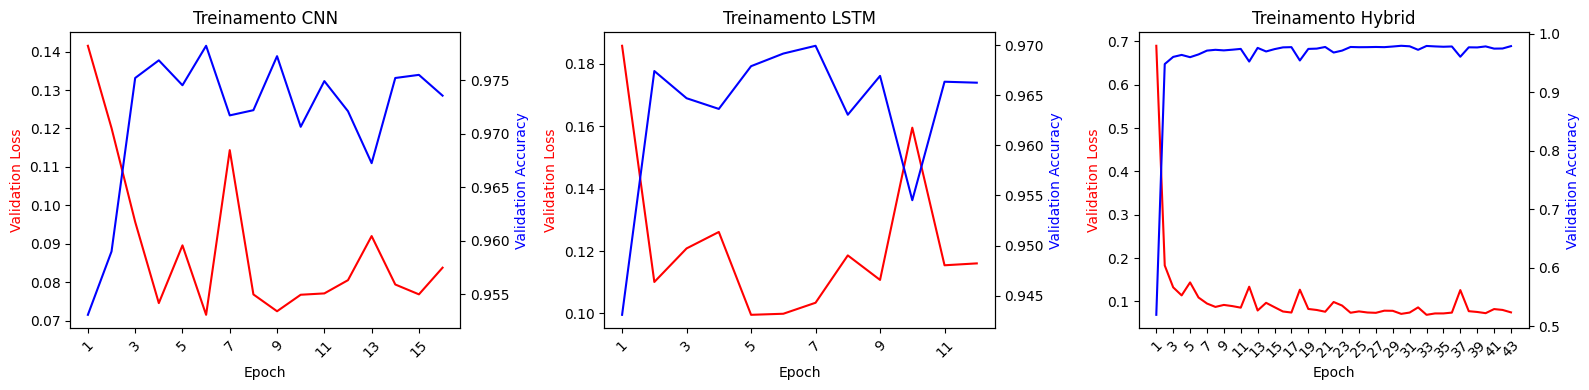

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Dicionário com os caminhos dos arquivos CSV
modelos = {
    'CNN': 'output/CNN/CNN_epoch_metrics.csv',
    'LSTM': 'output/LSTM/LSTM_epoch_metrics.csv',
    'Hybrid': 'output/Hybrid/Hybrid_epoch_metrics.csv'
}

fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=False)

for ax, (nome, caminho) in zip(axes, modelos.items()):
    df = pd.read_csv(caminho)

    # Eixo da esquerda - Validation Loss
    ax.plot(df['epoch'], df['val_loss'], color='red')
    ax.set_ylabel('Validation Loss', color='red')  # só o label em vermelho
    ax.set_xlabel('Epoch')
    ax.set_title(f'Treinamento {nome}')
    ax.set_xticks(df['epoch'][::2])
    ax.tick_params(axis='x', labelrotation=45)
    ax.tick_params(axis='y', colors='black')  # mantem os números em preto

    # Eixo da direita - Validation Accuracy
    ax2 = ax.twinx()
    ax2.plot(df['epoch'], df['val_acc'], color='blue')
    ax2.set_ylabel('Validation Accuracy', color='blue')  # só o label em azul
    ax2.tick_params(axis='y', colors='black')  # mantém os números em preto

plt.tight_layout()
plt.show()
